# $$\varpi \sim \kappa\nabla^2 b = \kappa \Big[\frac{\partial b}{\partial \theta} (\nabla^2 \theta) + \frac{\partial b}{\partial s} (\nabla^2 s)\Big]$$

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39381")
client

<Client: 'tcp://127.0.0.1:39381' processes=8 threads=40, memory=157.39 GiB>

In [11]:
client.restart()

distributed.client - ERROR - Restart timed out after 20.00 seconds


Connection method: Direct,
Dashboard: http://127.0.0.1:8787/status,
Comm: tcp://127.0.0.1:40063,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 20 hours ago,Total memory: 0 B


In [2]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rho0 = 9.998e2
Cp = 3.994e3
ystart = -15
yend = 50
dnf = 2160
nfile = 73
xchunk = 200
ychunk = 200
t_of_interest = 1

In [6]:
years = np.arange(1968,2008,dtype=int)
ntimes = np.arange(1578960,7886160,dnf).reshape(len(years),nfile)
yystart = 25
dd = 0
# years = np.arange(1963,2013,dtype=int)
# ntimes = np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile)
# dd = 42
# yystart = 0
print(years[yystart],ntimes[yystart,dd:])

1993 [5520960 5523120 5525280 5527440 5529600 5531760 5533920 5536080 5538240
 5540400 5542560 5544720 5546880 5549040 5551200 5553360 5555520 5557680
 5559840 5562000 5564160 5566320 5568480 5570640 5572800 5574960 5577120
 5579280 5581440 5583600 5585760 5587920 5590080 5592240 5594400 5596560
 5598720 5600880 5603040 5605200 5607360 5609520 5611680 5613840 5616000
 5618160 5620320 5622480 5624640 5626800 5628960 5631120 5633280 5635440
 5637600 5639760 5641920 5644080 5646240 5648400 5650560 5652720 5654880
 5657040 5659200 5661360 5663520 5665680 5667840 5670000 5672160 5674320
 5676480]


In [25]:
DiffE = - (-grid.diff(dsocn.DFrE_TH,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_TH,'X') * Vol_r
           + grid.diff(dsocn.DFyE_TH,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_TH,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_TH.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
swfrac = .62 * np.exp(dsocn.Zl/.6) + (1-.62) * np.exp(dsocn.Zl/20.)
swfrac1 = .62 * np.exp(dsocn.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsocn.Zl.shift(Zl=-1)/20.)
Qsw = (dsocn.oceQsw / (rho0*Cp) / (dsocn.drF*dsocn.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsocn.maskC!=0.)
Tflx = ((dsocn.TFLUX - dsocn.oceQsw) 
        / (rho0*Cp*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
tsurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsocn.WTHMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaT = (DiffE + DiffI + Kpp + Qsw).load()
DibaT[:,0] += (Tflx + Surf_corr).load().data
DibaT.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan # exclude Mediterranian relaxation
DibaT

NameError: name 'dsocn' is not defined

In [35]:
DiffE = - (-grid.diff(dsocn.DFrE_SLT,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_SLT,'X') * Vol_r
           + grid.diff(dsocn.DFyE_SLT,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_SLT,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_SLT.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
Sflx = (dsocn.SFLUX 
        / (rho0*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
ssurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsocn.WSLTMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaS = (DiffE + DiffI + Kpp).load()
DibaS[:,0] += (Sflx + Surf_corr).load().data
DibaS.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
DibaS

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [-6.96813913e-08, -7.07455570e-08, -6.58648673e-08, ...,
          -1.66865277e-07, -1.34897405e-07, -8.92233629e-08],
         [-7.32641396e-08, -9.15064717e-08, -9.92766260e-08, ...,
          -1.35127678e-07, -1.17853745e-07, -8.54999982e-08],
         ...,
         [ 5.27351531e-08,  4.60823335e-09, -2.71164655e-08, ...,
           9.00551882e-08,  7.20601605e-08,  6.82864965e-08],
         [ 4.76446935e-08,  6.27128349e-09, -4.95902563e-09, ...,
           6.18368503e-08,  6.45586411e-08,  6.22014227e-08],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 1.74994312e-07,  8.20

In [7]:
yy = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd:15]
#         mtimes = ntimes[yy,:]
    else:
        mtimes = ntimes[yy]
    for itime in mtimes:
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,year)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             prefix=['diag_ocnTave','diag_ocnSurf'], 
                             delta_t=2e2, iters=itime,
                            ).chunk({'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk})

        
        if itime == mtimes[0]:
            xA = ds.hFacW * ds.dyG * ds.drF
            yA = ds.hFacS * ds.dxG * ds.drF
            dxC_r = ds.dxC**-1
            dyC_r = ds.dyC**-1
            dxG_r = ds.dxG**-1
            dyG_r = ds.dyG**-1
            drF_r = ds.drF**-1
            drC_r = ds.drC**-1
            hFacC_r = ds.hFacC**-1
            rA_r = ds.rA**-1
            pres = rho0*grav*(-ds.Z) * 1e-4  # convert to [dbar]
            grid = Grid(ds, periodic=['X'])
            
        theta = ds.THETA.where(ds.maskC!=0.)
        salt = ds.SALT.where(ds.maskC!=0.)
        
        rho = xr.apply_ufunc(densjmd95, salt, theta, pres,            # pressure in [dbar]!!!!
                             dask='parallelized', output_dtypes=[float,]
                            ).where(ds.maskC!=0.)
        rho_s = xr.apply_ufunc(drhods, salt, theta, pres,             # pressure in [dbar]!!!!
                               dask='parallelized', output_dtypes=[float,]
                              ).where(ds.maskC!=0.)
        rho_th = xr.apply_ufunc(drhodt, salt, theta, pres,            # pressure in [dbar]!!!!
                                dask='parallelized', output_dtypes=[float,]
                               ).where(ds.maskC!=0.)
        
        dTdx = xA * grid.diff(ds.THETA,'X') * dxC_r
        dTdy = yA * grid.diff(ds.THETA,'Y',boundary='fill') * dyC_r
        del2T = rA_r * drF_r * hFacC_r * (grid.diff(dTdx,'X') 
                                          + grid.diff(dTdy,'Y',boundary='fill')
                                         )
######### xA for the harmonic term is already in dTdx
        FxT_diff = -Kh*dTdx + K4*xA*dxC_r*grid.diff(del2T,'X')
######### yA for the harmonic term is already in dTdy
        FyT_diff = -Kh*dTdy + K4*yA*dyC_r*grid.diff(del2T,'Y',boundary='fill')
        FrT_diff = -Kr*ds.rA * drC_r * -grid.diff(ds.THETA,'Z',boundary='fill',to='outer')
        
        dSdx = xA * grid.diff(ds.SALT,'X') * dxC_r
        dSdy = yA * grid.diff(ds.SALT,'Y',boundary='fill') * dyC_r
        del2S = rA_r * drF_r * hFacC_r * (grid.diff(dSdx,'X') 
                                          + grid.diff(dSdy,'Y',boundary='fill')
                                         )
######### xA for the harmonic term is already in dSdx
        FxS_diff = -Kh*dSdx + K4*xA*dxC_r*grid.diff(del2S,'X')
######### yA for the harmonic term is already in dSdy
        FyS_diff = -Kh*dSdy + K4*yA*dyC_r*grid.diff(del2S,'Y',boundary='fill')
        FrS_diff = -Kr*ds.rA * drC_r * -grid.diff(ds.SALT,'Z',boundary='fill',to='outer')
        
        
        GT_diff = -(grid.diff(FxT_diff,'X').where(ds.maskInC!=0.) 
                    + grid.diff(FyT_diff,'Y',boundary='fill').where(ds.maskInC!=0.)
                    - grid.diff(FrT_diff,'Z',boundary='fill')
                   ) * hFacC_r * drF_r * rA_r
        GS_diff = -(grid.diff(FxS_diff,'X').where(ds.maskInC!=0.) 
                    + grid.diff(FyS_diff,'Y',boundary='fill').where(ds.maskInC!=0.)
                    - grid.diff(FrS_diff,'Z',boundary='fill')
                   ) * hFacC_r * drF_r * rA_r
        
#         if itime == mtimes[0]:
#             fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,14))
#             fig.set_tight_layout(True)
#             GT_diff.isel(time=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax1, vmax=1e-7)
#             GS_diff.isel(time=0,Z=15).sel(YC=slice(-15,50+12**-1)).plot(ax=ax2, vmax=1e-8)
#             plt.show()
            
        dsave = (rho_th*GT_diff).sel(YC=slice(ystart-12**-1,
                                              yend+2*12**-1)
                                    ).compute().to_dataset(name='VarpiT')
        dsave['VarpiS'] = (rho_s*GS_diff).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).compute()
        dsave['rho'] = rho.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).compute()
#         chunks = {'Z':-1,'YC':ychunk,'XC':xchunk}
        dsave.to_zarr(op.join(tdgs,'Varpi_5Dave/memb%02d/run%4d/%010d/' 
                              % (0,year,itime)), mode='w')
        ds.close()
        dsave.close()
    
        print(itime)
#     print(year)
    yy += 1

5520960
5523120
5525280
5527440
5529600
5531760
5533920
5536080
5538240
5540400
5542560
5544720
5546880
5549040
5551200


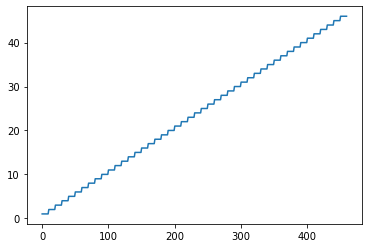

In [40]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            10)
# drc_finer, _, _, _ = finegrid.finegrid(np.squeeze(dsocn.drC.isel(Zp1=slice(None,-1))),
#                                       np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
#                                       10)

plt.plot(cellindex)

In [41]:
Dsig = 9.7
nlayers = 43

tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [76]:
GTdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XC),len(siglayers))),
                    dims=['nmemb','YC','XC','sig'],
                    coords={'nmemb':range(2),
                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
Gsdz = GTdz.copy()
Tdz = GTdz.copy()
sdz = GTdz.copy()

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          DibaT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          DibaS[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dsocn.THETA[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)
                                                                    ),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          dsocn.SALT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
#     if tt == 0:
#         GTdz = tmp1
#         Gsdz = tmp2
# #         dzetaF = tmpdzetaF
#     else:
#         GTdz = xr.concat([GTdz, tmp1], dim='nmemb')
#         Gsdz = xr.concat([Gsdz, tmp2], dim='nmemb')
# #         dzetaF = xr.concat([dzetaF, tmpdzetaF], dim='time')
    GTdz[tt] = tmp1
    Gsdz[tt] = tmp2
    Tdz[tt] = tmp3
    sdz[tt] = tmp4
    
    del tmp1, tmp2, tmp3, tmp4

    
GTdz = GTdz.chunk({'nmemb':1,'sig':1})
Gsdz = Gsdz.chunk({'nmemb':1,'sig':1})
Tdz = Tdz.chunk({'nmemb':1,'sig':1})
sdz = sdz.chunk({'nmemb':1,'sig':1})
GTdz

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [53]:
dzetaF = GTdz.load().copy() * np.nan
# dzetaF.coords['time'] = ('time',ds.time.data)

for j in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(rho2[j]).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)
                                                                          ).chunk({'XC':xchunk}),
                          (rho2[j]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                            yend+2*12**-1)
                                                                  ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
            #                            output_core_dims=(['sig2lev']),
            #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
            
    dzetaF[j] = tmp1.data
    
    del tmp1
    
dzetaF = dzetaF.chunk({'nmemb':1,'sig':1})
dzetaF

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [54]:
dssig = dzetaF.to_dataset(name='dzetaF')
dssig.coords['YG'] = ('YG',dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsocn.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
# dt = np.diff(ds.time)[0]
# dssig.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,
#                                                        .5*(ds.time[1:].data+ds.time[:-1].data)),
#                                              ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 2, sig: 43, sigp1: 44)
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
Data variables:
    dzetaF   (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 1000, 1), meta=np.ndarray>

In [55]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}}
             )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [96]:
sigma = (dzetaF * grids.diff(dssig.sigp1,'Z',boundary='fill')**-1)
zeta = -grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),'Z',boundary='fill')
sigma

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [63]:
angle = np.sqrt(1 + (dzetaF/grid.interp(dsocn.dxG,'Y',boundary='fill'))**2 
                + (dzetaF/grid.interp(dsocn.dyG,'X'))**2
               )**-1
angley = np.sqrt(1 + (grids.interp(dzetaF,'Y',boundary='fill')/dsocn.dxG)**2 
                + (grids.interp(dzetaF,'Y',boundary='fill')
                   / grid.interp(grid.interp(dsocn.dyG,'X'),'Y',boundary='fill')
                  )**2
                )**-1
anglex = np.sqrt(1 + (grids.interp(dzetaF,'X')
                      / grid.interp(grid.interp(dsocn.dxG,'Y',boundary='fill'),'X')
                     )**2 
                + (grids.interp(dzetaF,'X')/dsocn.dyG)**2
                )**-1
anglez = np.sqrt(1 + (grids.interp(dzetaF,'Z',boundary='fill')
                      / grid.interp(dsocn.dxG,'Y',boundary='fill')
                     )**2 
                 + (grids.interp(dzetaF,'Z',boundary='fill')
                    / grid.interp(dsocn.dyG,'X')
                   )**2
                )**-1
print(angle,angley,anglex,anglez)

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2 <xarray.DataArray (nmemb: 2, YG: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 722, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rAs      (YG, XC) >f4 87285460.0 87285460.0 ... 56830530.0 56830530.0
    dxG      

In [71]:
rAb = angle**-1 * dsocn.rA
rAbw = anglex**-1 * dsocn.rAw
rAbs = angley**-1 * dsocn.rAs
rAbz = anglez**-1 * dsocn.rA
rAb

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

In [77]:
dbdT = grids.diff(Tdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )
dbds = grids.diff(sdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )

varpi = (dbdT*grids.interp(GTdz*dzetaF**-1,'Z',boundary='fill') 
         + dbds*grids.interp(Gsdz*dzetaF**-1,'Z',boundary='fill')
        )
varpi

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sigp1: 44)>
dask.array<add, shape=(2, 723, 1000, 44), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

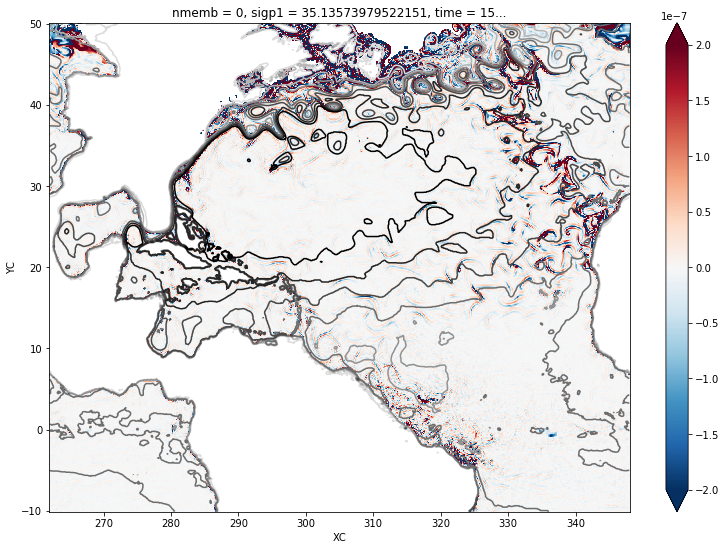

In [94]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[0,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[0,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)

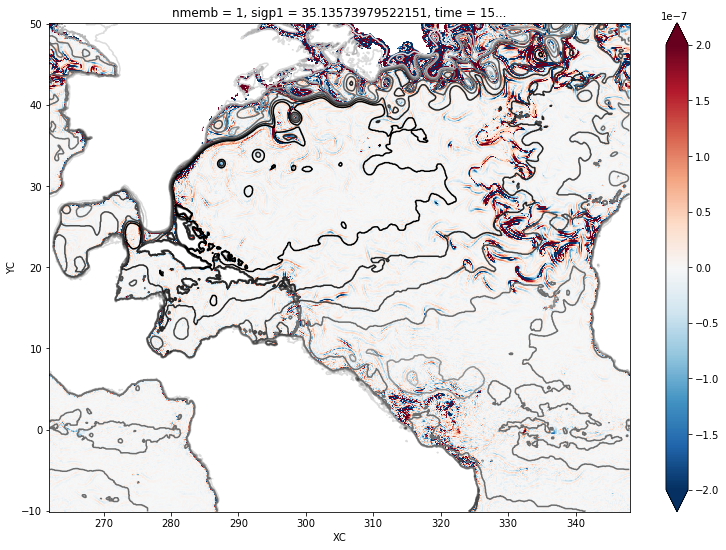

In [95]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[1,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[1,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)